In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime
import json

In [6]:
store_100_path = r"df_all_store_100.parquet"
store_42_path = r"df_all_store_42.parquet"
store_4906_path = r"df_all_store_4906.parquet"

In [7]:
pl.Config.set_fmt_str_lengths(314)
pl.Config.set_tbl_cols(20)
pl.Config.set_tbl_rows(314)

polars.config.Config

In [8]:
df_100 = pl.read_parquet(store_100_path).drop(columns=["__index_level_0__"])
df_all = df_100.clone()

In [9]:
del df_100

In [10]:
df_42 = pl.read_parquet(store_42_path).drop(columns=["__index_level_0__"])

In [11]:
df_all = pl.concat([df_all, df_42])

In [12]:
del df_42

In [13]:
df_4906 = pl.read_parquet(store_4906_path).drop(columns=["__index_level_0__"])

In [14]:
df_all = pl.concat([df_all, df_4906])

In [15]:
del df_4906

In [16]:
print(f"Memory usage of dataframe is df_all {round(df_all.estimated_size('mb'), 2)} MB")

Memory usage of dataframe is df_all 8487.11 MB


# read data from warehouse

In [17]:
waerhouse_path = r"df_all_store_VZ01.parquet"
df_warehouse = pl.read_parquet(waerhouse_path).drop(columns=["__index_level_0__"])

In [18]:
df_warehouse = df_warehouse.with_columns(pl.col('sku').cast(pl.Utf8))

In [19]:
df_warehouse = df_warehouse.rename({"stock": "warehouse_stock"})

# join data

In [20]:
df_step1 = df_all.join(df_warehouse[["sku","date","warehouse_stock"]], on = ["sku","date"], how = "left")

In [21]:
df_step1 = df_step1.with_columns(pl.col('warehouse_stock').fill_null(0))

In [22]:
df_step1 = df_step1.sort(['sku',"store",'date'])

In [23]:
df_step1 =df_step1.with_columns((pl.col("warehouse_stock").diff().over(["store","sku"]).alias("warehouse_stock_change").fill_nan(0)))

In [24]:
df_step1 = df_step1.with_columns(pl.col('stock').diff().over(["store","sku"]).alias("stock_change").fill_nan(0))

In [25]:
del df_all, df_warehouse

In [26]:
filtered_df_stock = df_step1.filter(pl.col('stock') > 0)
result_df_stock_non_zeros = filtered_df_stock.with_columns(pl.col('stock').first().over(["store","sku"]).alias("first_stock"))

# read dict of stores distribution

In [27]:
dict_per_store_per_year_path = r"dict_per_store_per_year.json"
with open(dict_per_store_per_year_path) as json_file:
    dict_per_store_per_year = json.load(json_file)

In [28]:
dict_per_store_per_year_2022 = dict_per_store_per_year["2022"]

# view

In [29]:
print(df_step1.shape)

(73632871, 12)


In [30]:
dict_per_store_per_year_2022["100"], dict_per_store_per_year_2022["42"], dict_per_store_per_year_2022["82"]

(0.037152098092696574, 0.02105508186996078, 0.0221345022634434)

In [31]:
print(df_step1.head(30))

shape: (30, 12)
┌────────┬───────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sku    ┆ store ┆ date   ┆ averag ┆ avera ┆ sales ┆ item  ┆ sku_s ┆ stock ┆ wareh ┆ wareh ┆ stock │
│ ---    ┆ ---   ┆ ---    ┆ e_pric ┆ ge_di ┆ ---   ┆ ---   ┆ tore  ┆ ---   ┆ ouse_ ┆ ouse_ ┆ _chan │
│ str    ┆ str   ┆ dateti ┆ e      ┆ count ┆ f64   ┆ str   ┆ ---   ┆ f64   ┆ stock ┆ stock ┆ ge    │
│        ┆       ┆ me[ns] ┆ ---    ┆ ed_pr ┆       ┆       ┆ str   ┆       ┆ ---   ┆ _chan ┆ ---   │
│        ┆       ┆        ┆ f64    ┆ ice   ┆       ┆       ┆       ┆       ┆ f64   ┆ ge    ┆ f64   │
│        ┆       ┆        ┆        ┆ ---   ┆       ┆       ┆       ┆       ┆       ┆ ---   ┆       │
│        ┆       ┆        ┆        ┆ f64   ┆       ┆       ┆       ┆       ┆       ┆ f64   ┆       │
╞════════╪═══════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 100009 ┆ 100   ┆ 2018-0 ┆ null   ┆ null  ┆ 0.0   ┆ 10000 ┆ 10000 ┆ 0.0   

In [32]:
max_sku_temp = 100630105000002

In [33]:
sku_temp = df_step1.filter((pl.col('sku').is_in(100630105000002))).select(pl.col(["date","stock",'warehouse_stock_change',"sales","stock_change","store","warehouse_stock"]))

In [34]:
stock_init_warehouse_sku = sku_temp.with_columns(pl.col('warehouse_stock').first().over(["store"]).alias("first_stock"))

In [35]:
print(stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0])

3165.0


In [36]:
dict_per_store_per_year_2022["100"]

0.037152098092696574

In [37]:
dict_per_store_per_year_2022["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

117.58639046338466

In [38]:
dict_per_store_per_year["2020"]["100"]

0.03250624160289353

In [39]:
dict_per_store_per_year["2020"]["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

102.88225467315803

In [40]:
dict_per_store_per_year["2019"]["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

133.5723185928597

In [41]:
dict_per_store_per_year_2022["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

66.63933411842586

In [42]:
dict_per_store_per_year["2020"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

58.52620685217021

In [43]:
dict_per_store_per_year["2019"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

57.19070811057481

In [44]:
dict_per_store_per_year["2018"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

59.36505388212157

In [45]:
print(sku_temp.filter(pl.col("store")=="100").select(pl.col(["sales"])).sum())

shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 51.0  │
└───────┘


In [46]:
print(sku_temp.filter(pl.col("store")=="42").select(pl.col(["sales"])).sum())

shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 53.0  │
└───────┘


In [47]:
print(sku_temp.filter(pl.col("store")=="4906").select(pl.col(["sales"])).sum())


shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 22.0  │
└───────┘


In [48]:
print(sku_temp.filter(pl.col("store")=="100").filter(pl.col('stock_change')<0).sum())

shape: (1, 7)
┌──────────────┬───────┬────────────────────────┬───────┬──────────────┬───────┬─────────────────┐
│ date         ┆ stock ┆ warehouse_stock_change ┆ sales ┆ stock_change ┆ store ┆ warehouse_stock │
│ ---          ┆ ---   ┆ ---                    ┆ ---   ┆ ---          ┆ ---   ┆ ---             │
│ datetime[ns] ┆ f64   ┆ f64                    ┆ f64   ┆ f64          ┆ str   ┆ f64             │
╞══════════════╪═══════╪════════════════════════╪═══════╪══════════════╪═══════╪═════════════════╡
│ null         ┆ 370.0 ┆ -276.0                 ┆ 13.0  ┆ -53.0        ┆ null  ┆ 9589.0          │
└──────────────┴───────┴────────────────────────┴───────┴──────────────┴───────┴─────────────────┘


In [49]:
print(sku_temp.filter(pl.col("store")=="42").filter(pl.col('stock_change')<0).sum())

shape: (1, 7)
┌──────────────┬───────┬────────────────────────┬───────┬──────────────┬───────┬─────────────────┐
│ date         ┆ stock ┆ warehouse_stock_change ┆ sales ┆ stock_change ┆ store ┆ warehouse_stock │
│ ---          ┆ ---   ┆ ---                    ┆ ---   ┆ ---          ┆ ---   ┆ ---             │
│ datetime[ns] ┆ f64   ┆ f64                    ┆ f64   ┆ f64          ┆ str   ┆ f64             │
╞══════════════╪═══════╪════════════════════════╪═══════╪══════════════╪═══════╪═════════════════╡
│ null         ┆ 442.0 ┆ -381.0                 ┆ 7.0   ┆ -55.0        ┆ null  ┆ 13714.0         │
└──────────────┴───────┴────────────────────────┴───────┴──────────────┴───────┴─────────────────┘


In [50]:
# sku_temp.filter(pl.col("store")=="42").select(pl.col(["date","stock",'warehouse_stock_change',"sales","stock_change","store","warehouse_stock"]))

# dict compare dist caculation to actual from sales

In [51]:
stock_init_warehouse_sku = df_step1.filter(pl.col("warehouse_stock")>0).groupby(["sku"]).agg(pl.col("warehouse_stock").first().alias("total_stock_from_warehouse"))

In [52]:
their_suggestion_stock_init = df_step1.filter(pl.col("stock")>0).groupby(["sku"]).agg(pl.col("stock").first().alias("palmers_suggest_stock_init"))

In [53]:
df_step1.filter(pl.col("sku")=="100090841000004")

sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change
str,str,datetime[ns],f64,f64,f64,str,str,f64,f64,f64,f64
"""100090841000004""","""100""",2017-12-20 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,null,null
"""100090841000004""","""100""",2017-12-21 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-22 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-23 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-24 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-25 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-26 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-27 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-28 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0


In [54]:
print(stock_init_warehouse_sku.head(3))

shape: (3, 2)
┌─────────────────┬────────────────────────────┐
│ sku             ┆ total_stock_from_warehouse │
│ ---             ┆ ---                        │
│ str             ┆ f64                        │
╞═════════════════╪════════════════════════════╡
│ 100079527000001 ┆ 629.0                      │
│ 100628138000010 ┆ 180.0                      │
│ 100618477000005 ┆ 247.0                      │
└─────────────────┴────────────────────────────┘


In [55]:
stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())["sku"]

sku
str
"""100635005000001"""
"""100641476000002"""
"""100637000000004"""
"""100532634000005"""
"""100643061000007"""
"""100080095000001"""
"""100630339000003"""
"""100533027000003"""
"""100549882000001"""


In [56]:
stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())

sku,total_stock_from_warehouse
str,f64
"""100530095000001""",1.0
"""100530663000002""",525.0
"""100657000000002""",383.0
"""100654318000002""",1477.0
"""100548040000003""",747.0
"""100618253000004""",350.0
"""100630349000002""",1185.0
"""100559221000005""",325.0
"""100539363000002""",48.0


In [57]:
temp_100_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
temp_42_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
temp_4906_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["4906"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()

In [58]:
temp_100_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
temp_42_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
temp_4906_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["4906"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()

In [59]:
temp_4906_our

,sku,literal
0,100537832000003,1.0
1,100539111000004,0.0
2,100657008000001,1.0
3,100620208000001,0.0
4,100624318000002,1.0
...,...,...
22074,100062164000001,0.0
22075,100551124000001,1.0
22076,100549876000001,0.0
22077,100643285000001,1.0


In [60]:
# temp_100_our.with_columns(pl.col("store").fill_null("100"))
# temp_42_our.with_columns(pl.col("store").fill_null("42"))

In [61]:
temp_42_our[temp_42_our['sku'] == '100630105000002']

,sku,literal
8947,100630105000002,20.0


In [62]:
temp_100_our[temp_100_our['sku'] == '100630105000002']

,sku,literal
6560,100630105000002,34.0


In [63]:
temp_4906_our[temp_4906_our['sku'] == '100630105000002']


,sku,literal
7524,100630105000002,7.0


In [64]:
sales_100 = df_step1.filter(pl.col("store")=="100").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
sales_42 = df_step1.filter(pl.col("store")=="42").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
sales_4906 = df_step1.filter(pl.col("store")=="4906").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()

In [65]:
temp_100_our['store'] = "100"
temp_42_our['store'] = "42"
temp_4906_our['store'] = "4906"
temp_42_100_our = pd.concat([temp_100_our, temp_42_our, temp_4906_our])


In [66]:
temp_42_our

,sku,literal,store
0,100549792000001,0.0,42
1,100553947000005,2.0,42
2,100659140000004,1.0,42
3,100552481000005,1.0,42
4,100630490000020,10.0,42
...,...,...,...
22074,100559254000013,0.0,42
22075,100628329000007,1.0,42
22076,100648068000005,4.0,42
22077,100650003000004,2.0,42


In [67]:
df_step1 = df_step1.to_pandas()

In [68]:
df_step1 = df_step1.merge(temp_42_100_our, on = ["sku", 'store'], how = "left")

In [69]:
df_step1 = df_step1.rename(columns={"literal": "sum_of_our_allocation_stock"})

In [70]:
f_sales_v = pd.read_csv(r"f_sales_v_fashion.csv")

In [71]:
f_sales_v_100 = f_sales_v[f_sales_v['store'] == 100]
f_sales_v_42 = f_sales_v[f_sales_v['store'] == 42]
f_sales_v_4906 = f_sales_v[f_sales_v['store'] == 4906]

In [72]:
f_sales_v_100

,sku,store,date,average_price,average_dicounted_price,total_sales
7,100009158000001,100,2018-01-30,69.99,69.99,1.0
8,100009158000001,100,2018-02-02,69.99,69.99,1.0
9,100009158000001,100,2018-02-14,69.99,69.99,3.0
10,100009158000001,100,2018-02-16,69.99,69.99,1.0
11,100009158000001,100,2018-02-17,69.99,69.99,1.0
...,...,...,...,...,...,...
4977652,201999999991001,100,2019-11-25,2.99,0.00,1.0
4977653,201999999991001,100,2019-12-17,2.99,2.99,1.0
4977654,201999999991001,100,2019-12-19,2.99,2.99,1.0
4977655,201999999991001,100,2020-12-21,2.99,2.99,2.0


In [73]:
sku_list_stock = set(temp_100_our['sku'].astype(str).unique()).intersection(temp_42_our['sku'].astype(str).unique(), temp_4906_our['sku'].astype(str).unique())
sku_list_f_sales_v = set(f_sales_v_100['sku'].astype(str).unique()).intersection(f_sales_v_42['sku'].astype(str).unique(), f_sales_v_4906['sku'].astype(str).unique())
sku_list = sku_list_stock.intersection(sku_list_f_sales_v)

In [74]:
df_step1 = df_step1[df_step1['sku'].isin(sku_list)]


In [75]:
sku_list

{'100618032000006',
 '100648051000002',
 '100552692000001',
 '100654318000002',
 '100628124000006',
 '100648010000003',
 '100652129000002',
 '100532533000002',
 '100528035000005',
 '100653219000008',
 '100559235000004',
 '100080123000001',
 '100631048000003',
 '100610036000002',
 '100552762000003',
 '100618104000003',
 '100620046000003',
 '100652563000001',
 '100633231000001',
 '100652201000002',
 '100632034000003',
 '100659160000002',
 '100085000000007',
 '100654279000004',
 '100642380000002',
 '100639003000005',
 '100548592000003',
 '100630138000002',
 '100653095000001',
 '100618157000008',
 '100528057000012',
 '100649200000003',
 '100618251000006',
 '100635155000004',
 '100620352000002',
 '100080143000002',
 '100559244000001',
 '100643375000002',
 '100518866000002',
 '100653138000005',
 '100552482000009',
 '100632048000004',
 '100652098000001',
 '100080009000002',
 '100653028000003',
 '100541035000004',
 '100633105000009',
 '100559128000002',
 '100559289000004',
 '100553843000002',


In [76]:
df_step1

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock
0,100009158000001,100,2018-01-05,NaN,NaN,0.0,100009158000,"100009158000001,100",0.0,508.0,NaN,NaN,6.0
1,100009158000001,100,2018-01-06,NaN,NaN,0.0,100009158000,"100009158000001,100",0.0,508.0,0.0,0.0,6.0
2,100009158000001,100,2018-01-07,NaN,NaN,0.0,100009158000,"100009158000001,100",0.0,508.0,0.0,0.0,6.0
3,100009158000001,100,2018-01-08,NaN,NaN,0.0,100009158000,"100009158000001,100",0.0,508.0,0.0,0.0,6.0
4,100009158000001,100,2018-01-09,NaN,NaN,0.0,100009158000,"100009158000001,100",0.0,508.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73605562,100659576000008,4906,2023-12-08,NaN,NaN,0.0,100659576000,"100659576000008,4906",2.0,0.0,0.0,0.0,1.0
73605563,100659576000008,4906,2023-12-09,NaN,NaN,0.0,100659576000,"100659576000008,4906",2.0,0.0,0.0,0.0,1.0
73605564,100659576000008,4906,2023-12-10,NaN,NaN,0.0,100659576000,"100659576000008,4906",2.0,0.0,0.0,0.0,1.0
73605565,100659576000008,4906,2023-12-11,NaN,NaN,0.0,100659576000,"100659576000008,4906",2.0,0.0,0.0,0.0,1.0


In [77]:
for id in sku_store_df_step_g.groups:
    sku_store_df_step = sku_store_df_step_g.get_group(id)
    sku_store_df_step['sales_cum_sum'] = sku_store_df_step['sales'].cumsum()
    sku_store_df_step['sales_normalized_by_days'] = sku_store_df_step['sales_cum_sum'] / sku_store_df_step['days_from_first_stock']
    sku_store_df_step['our_dynamic_stock'] = sku_store_df_step['sum_of_our_allocation_stock'] - sku_store_df_step['sales_cum_sum']
    sku_store_df_step.set_index('date')[['sum_of_our_allocation_stock','our_dynamic_stock', 'sales_cum_sum','stock']].plot(figsize=(17, 5))
    plt.title(f"sku {id[0]}, store {id[1]}")
    plt.show()


NameError: name 'sku_store_df_step_g' is not defined

In [79]:
sku_store_df_step_g = df_step1.groupby(["sku", "store"])


1 100630105000002 42


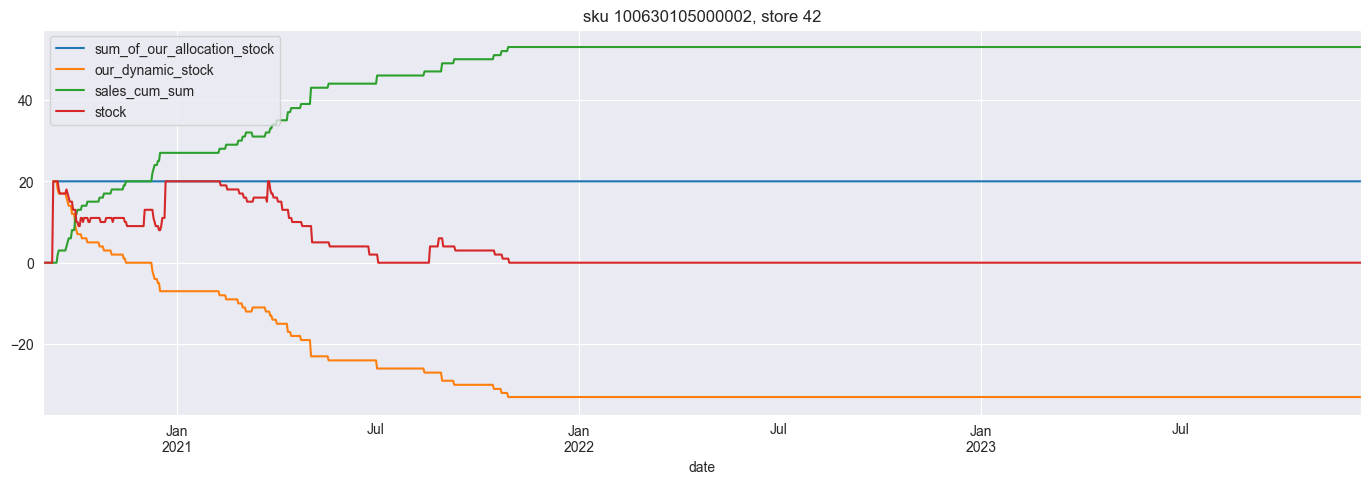

2 100630105000002 100


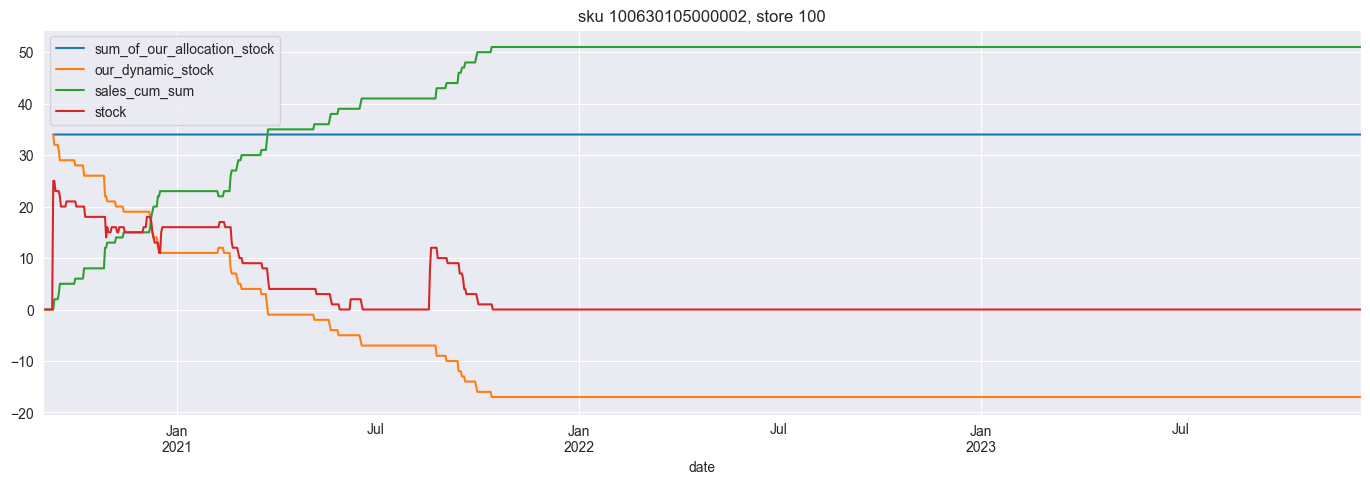

3 100630105000002 4906


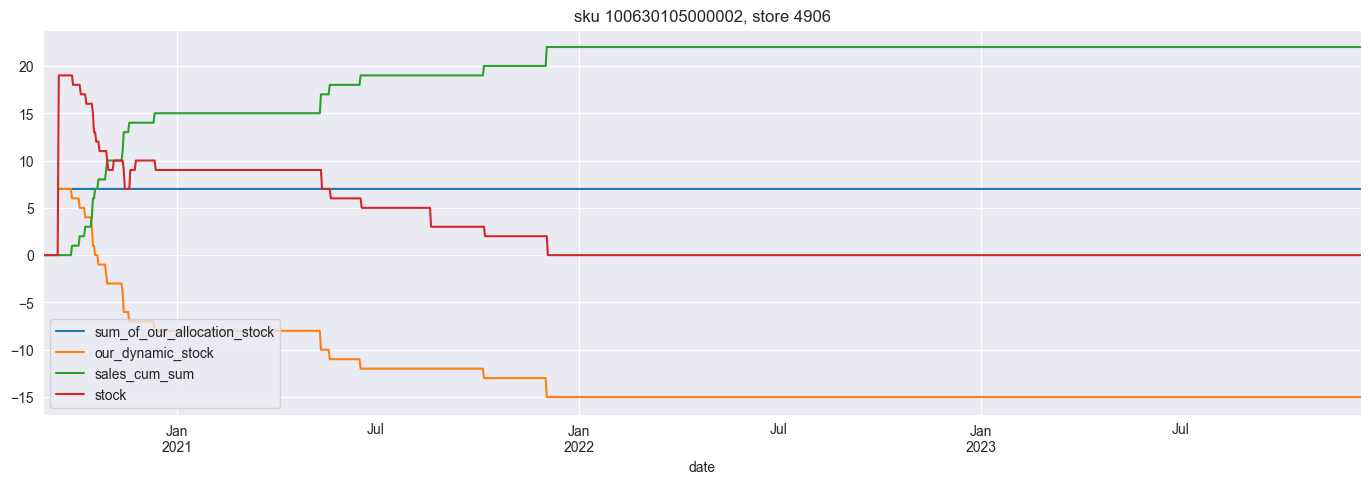

In [80]:
#import plt
import warnings
warnings.filterwarnings('ignore')
df_step1['date'] = pd.to_datetime(df_step1['date'])
import matplotlib.pyplot as plt
dict_when_our_stock_go_to_zero = {}
i = 0
for store in ['42', '100', '4906']:
    dict_when_our_stock_go_to_zero[store] = {}
    for sku in ['100630105000002']:

        i += 1
        print(i, sku, store)
        sku_store_df_step = sku_store_df_step_g.get_group((sku, store))
        # find in stock the first time that is not zero
        if len(sku_store_df_step[sku_store_df_step["stock"]>0]) == 0:
            continue
        first_stock = sku_store_df_step[sku_store_df_step["stock"]>0]["stock"].iloc[0]
        # nan in our_stock if before first stock
        sku_store_df_step.loc[sku_store_df_step["date"]<sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "sum_of_our_allocation_stock"] = np.nan
        # add number of days from first stock 1 2 3 4 5 6 7 8 9 10
        sku_store_df_step['days_from_first_stock'] = np.nan
        sku_store_df_step.loc[sku_store_df_step["date"]>=sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "days_from_first_stock"] = sku_store_df_step[sku_store_df_step["date"]>=sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0]].index - sku_store_df_step[sku_store_df_step["stock"]>0].index[0]

        sku_store_df_step['sales_cum_sum'] = sku_store_df_step['sales'].cumsum()
      #  sku_store_df_step['sales_normalized_by_days'] = sku_store_df_step['sales_cum_sum'] / sku_store_df_step['days_from_first_stock']
        sku_store_df_step['our_dynamic_stock'] = sku_store_df_step['sum_of_our_allocation_stock'] - sku_store_df_step['sales_cum_sum']
        sku_store_df_step.set_index('date')[['sum_of_our_allocation_stock','our_dynamic_stock', 'sales_cum_sum','stock']].plot(figsize=(17, 5))
        plt.title(f"sku {sku}, store {store}")
        plt.show()
        dict_when_our_stock_go_to_zero[store][sku] = {}
        if sku_store_df_step.dropna(subset='our_dynamic_stock')['our_dynamic_stock'].iloc[0] > 0 :
            sku_store_df_step_no_na = sku_store_df_step.dropna(subset='our_dynamic_stock')
            if len(sku_store_df_step_no_na[sku_store_df_step_no_na['our_dynamic_stock'] <= 0]) > 0:
                value_of_days_to_zero_our_stock =  sku_store_df_step_no_na[sku_store_df_step_no_na['our_dynamic_stock'] <= 0]['days_from_first_stock'].iloc[0]
                if value_of_days_to_zero_our_stock > 365:
                    value_of_days_to_zero_our_stock = 365
                if value_of_days_to_zero_our_stock == 1:
                    if sku_store_df_step_no_na['stock'].iloc[0] == 1:
                        continue


                dict_when_our_stock_go_to_zero[store][sku] = value_of_days_to_zero_our_stock



In [ ]:
sku_store_df_step.iloc[:20]

In [ ]:
dict_when_our_stock_go_to_zero_pd = pd.DataFrame.from_dict(dict_when_our_stock_go_to_zero['42'], orient='index', columns=['days_to_zero_our_stock'])
dict_when_our_stock_go_to_zero_pd = pd.concat([dict_when_our_stock_go_to_zero_pd, pd.DataFrame.from_dict(dict_when_our_stock_go_to_zero['100'], orient='index', columns=['days_to_zero_our_stock'])])
dict_when_our_stock_go_to_zero_pd = pd.concat([dict_when_our_stock_go_to_zero_pd, pd.DataFrame.from_dict(dict_when_our_stock_go_to_zero['4906'], orient='index', columns=['days_to_zero_our_stock'])])

### hist of how many days initial stock of 1/3 go to zero

In [ ]:
dict_when_our_stock_go_to_zero_pd.hist(bins=365, figsize=(17, 5))

In [ ]:
sku_store_df_step[sku_store_df_step["stock"]>0]

In [ ]:
dict_when_our_stock_go_to_zero

In [ ]:
sku_store_df_step_no_na

In [145]:
sku_store_df_step_no_na = sku_store_df_step.dropna(subset='our_dynamic_stock')
sku_store_df_step_no_na[sku_store_df_step_no_na['sum_of_our_allocation_stock'] <= 0]

IndexError: single positional indexer is out-of-bounds

In [133]:
sku_store_df_step.iloc[-20:]

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock,days_from_first_stock,sales_cum_sum,our_dynamic_stock
45545496,100618213000008,100,2023-11-23,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,842.0,2.0,0.0
45545497,100618213000008,100,2023-11-24,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,843.0,2.0,0.0
45545498,100618213000008,100,2023-11-25,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,844.0,2.0,0.0
45545499,100618213000008,100,2023-11-26,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,845.0,2.0,0.0
45545500,100618213000008,100,2023-11-27,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,846.0,2.0,0.0
45545501,100618213000008,100,2023-11-28,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,847.0,2.0,0.0
45545502,100618213000008,100,2023-11-29,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,848.0,2.0,0.0
45545503,100618213000008,100,2023-11-30,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,849.0,2.0,0.0
45545504,100618213000008,100,2023-12-01,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,850.0,2.0,0.0
45545505,100618213000008,100,2023-12-02,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,851.0,2.0,0.0


In [122]:
sku_store_df_step.iloc[:20]

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock,days_from_first_stock,sales_cum_sum,our_dynamic_stock
45544641,100618213000008,100,2021-07-21,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,NaN,NaN,NaN,NaN,0.0,NaN
45544642,100618213000008,100,2021-07-22,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544643,100618213000008,100,2021-07-23,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544644,100618213000008,100,2021-07-24,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544645,100618213000008,100,2021-07-25,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544646,100618213000008,100,2021-07-26,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544647,100618213000008,100,2021-07-27,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544648,100618213000008,100,2021-07-28,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544649,100618213000008,100,2021-07-29,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544650,100618213000008,100,2021-07-30,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN


In [95]:
'100531067000003' in temp_42_our['sku'].unique()

True

In [99]:
print(df_step1[(df_step1['sku'] == '100531067000003') & (df_step1['store'] == '4906')])

                      sku store       date  average_price  \
14612941  100531067000003  4906 2020-02-12            NaN   
14612942  100531067000003  4906 2020-02-13            NaN   
14612943  100531067000003  4906 2020-02-14            NaN   
14612944  100531067000003  4906 2020-02-14            NaN   
14612945  100531067000003  4906 2020-02-15            NaN   
...                   ...   ...        ...            ...   
14614338  100531067000003  4906 2023-12-08            NaN   
14614339  100531067000003  4906 2023-12-09            NaN   
14614340  100531067000003  4906 2023-12-10            NaN   
14614341  100531067000003  4906 2023-12-11            NaN   
14614342  100531067000003  4906 2023-12-12            NaN   

          average_dicounted_price  sales          item             sku_store  \
14612941                      NaN    0.0  100531067000  100531067000003,4906   
14612942                      NaN    0.0  100531067000  100531067000003,4906   
14612943                   

In [ ]:
sku_store_df_step.iloc[:50]

In [ ]:
sku_store_df_step.set_index('date')[['stock', 'sum_of_our_allocation_stock', 'sales', 'our_dynamic_stock']]

In [ ]:
for days in [20,40, 60, 80, 100]:
    slice_data = sku_store_df_step.iloc[:days]
    if slice_data['sales_cum_sum'].iloc[-1] >= slice_data['sum_of_our_allocation_stock'].iloc[-1] / 2:
        print(f"day: {days},")
        break


In [ ]:
slice_data